# GAN

 



In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf #텐서플로우 2.x 실행

In [2]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models
from tqdm.notebook import tqdm

학습이 된 Gan모델에 노이즈값을 넣은 뒤 예측한 이미지를 보여주는 함수입니다.

In [3]:
def plot_generated_images(epoch, generator):
    noise= np.random.normal(0, 1, [100, 100]) #100개의 노이즈 값을 생성합니다.
    make_images = generator.predict(noise) # 노이즈값을 통해서 GAN으로 이미지 생성합니다.
    make_images = make_images.reshape(100,28,28) # Mnist 사이즈와 동일하게 바꿔줍니다.
    plt.figure(figsize=(10,10)) # 이미지 크기 지정
    for i in range(make_images.shape[0]): #이미지 갯수 100만큼 반복
        plt.subplot(10, 10, i+1) #바둑판식으로 표현
        plt.imshow(make_images[i],plt.get_cmap('gray'))
        plt.axis('off')
    plt.tight_layout()

Compile에서 Adam optmizer를 호출이 가능하지만 세부조정이 어렵습니다. 
이번에는 Adam optimizer를 생성하는 함수를 만들었습니다.  

In [4]:
def adam_optimizer() : 
  return tf.keras.optimizers.Adam(0.001) # w <- w - a*G : a = learning_rate = 0.001

Vanilla GAN 모델링에 관한 코드입니다.  
GAN은 2개의 모델이 필수적으로 사용을 하게 됩니다.  

실제이미지와 가짜 이미지를 판별해주는 Discriminator  
가짜이미지를 생성하는 Generator 모델입니다.   

데이터는 Fashion Mnist데이터를 이용하여 실습하겠습니다.

Conv1D에서 Mnist 데이터를 학습을 시켰을 때는 /255를 통하여 0~1 사이의 실수를 만들었습니다.  

GAN에서는 -127.5를 뺀후 나누게 됩니다. 이러면 데이터가 -1 ~  1사이의 값이 됩니다.



In [5]:
(x_train, _), (_, _) = datasets.fashion_mnist.load_data() 
x_train = (x_train.astype(np.float32)-127.5)/127.5  
x_train = x_train.reshape(60000, 784) 

4423680/4422102 [==============================] - 0s 0us/step


Generator 모델을 만듭니다.  
입력데이터는 100개의 노이즈 이며 3층으로 쌓은 FFN 입니다.  
활성함수는 ReLU를 사용하였고, 마지막에는 Tanh를 사용하였습니다.  
Tanh를 사용한 것은 데이터를 정규화 시킬 때 음수의 값을 포함하여 하였기 때문에  
생성된 값 또한 음수를 표현을 하기 위해서 Tanh를 사용하게 되었습니다. 
  
Generator의 최종 결과는 784이고 이는 mnist의 이미지 크기와 동일합니다.


In [ ]:
generator=models.Sequential()
generator.add(layers.Dense(256,input_dim=100,activation='relu'))
generator.add(layers.Dense(512,activation='relu'))
generator.add(layers.Dropout(0.3))
generator.add(layers.Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

discriminator 모델을 만듭니다. 
입력데이터는 minist파일의 크기이며 3층으로 쌓은 FFN 모델입니다.  
Generator와 다르게 unit의 수가 점점 줄어드는 것을 확인 할 수 있습니다.  

마지막 활성함수는 sigmoid를 사용함으로서 0 1사이에 거짓 이미지인지 실제 이미지인지를 판별을 해주는 것입니다.  

In [ ]:
discriminator=models.Sequential()
discriminator.add(layers.Dense(512,input_dim=784,activation='relu'))
discriminator.add(layers.Dense(256,activation='relu'))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

generator를 학습시킬 때도, discriminator를 이용한다는 점을 기억하세요.   
discriminator가 예측한 값의 오차가 크면 generator는 좋은 것이고, 오차가 작으면 generator는 학습을 한참 더 해야하는 것입니다.  
이러한 특징으로 generator를 학습시키려면 generator로 만들어낸 이미지를 discriminator에 입력으로 넣어준다음 오차를 계산해야합니다. 그래서 다음과 같이 generator와 discriminator를 연결하는 코드를 추가로 작성해줍니다.  
  
  여기서의 핵심은 discriminator weight값을 변경을 못하게 하는 것입니다. 이를 위해 discriminator.trainable=False 와 같은 설정을 먼저 해줍니다.

In [ ]:
discriminator.trainable=False # weight 학습불가
gan_input = layers.Input(shape=(100,))
x = generator(gan_input)
gan_output= discriminator(x)
gan= models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
 x_train.shape[0]

60000

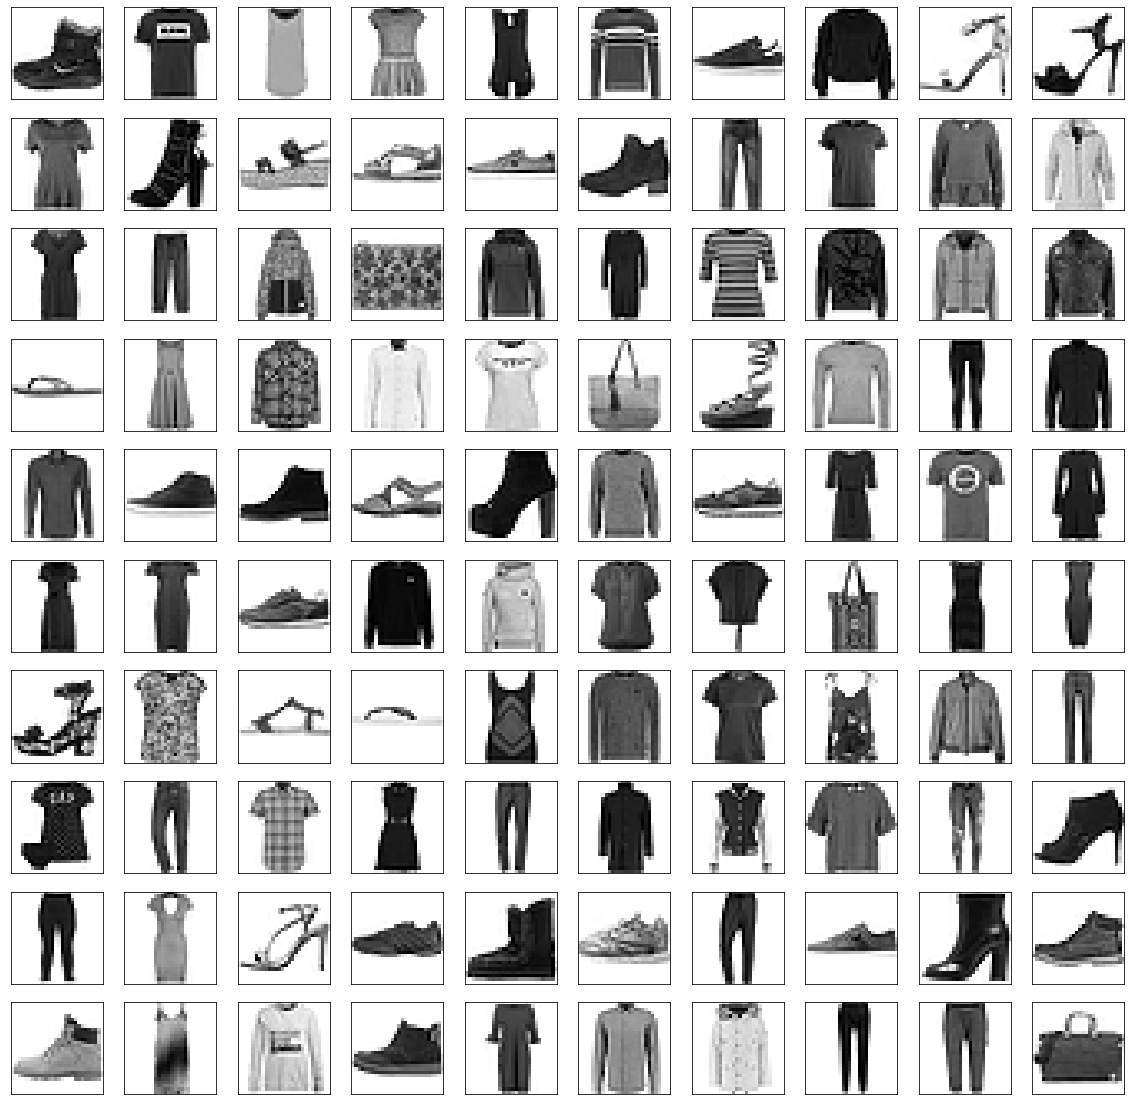

In [ ]:
# 최종 결과
plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28, 28), cmap=plt.cm.binary)
plt.show()

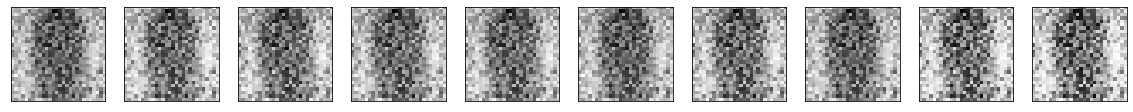

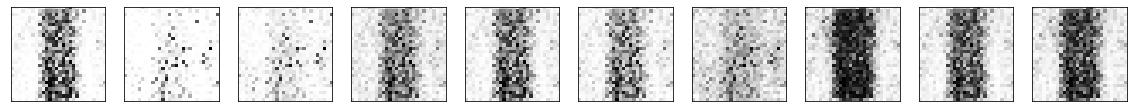

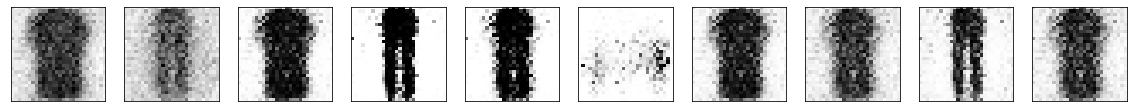

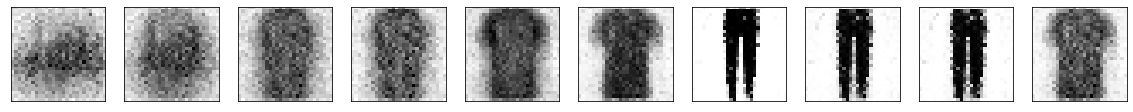

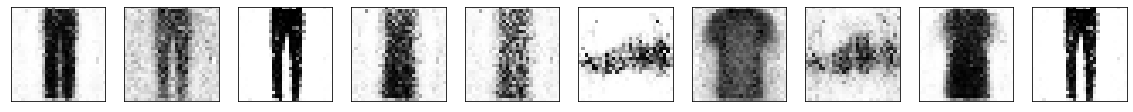

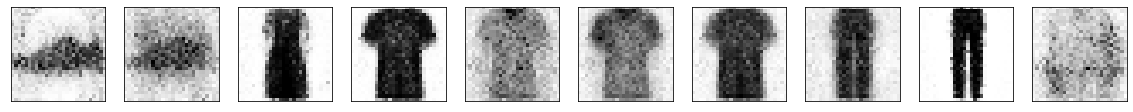

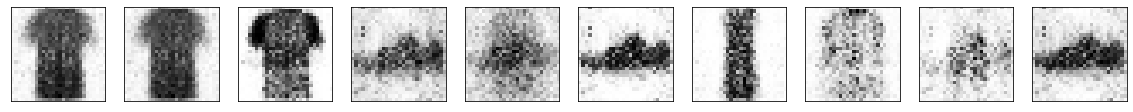

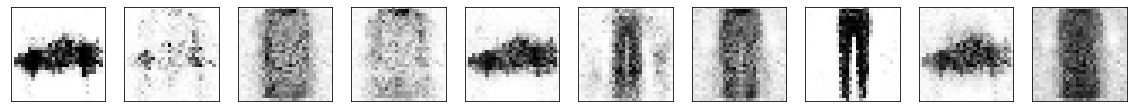

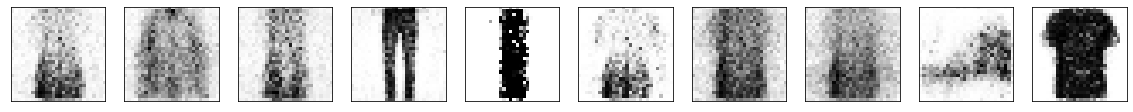

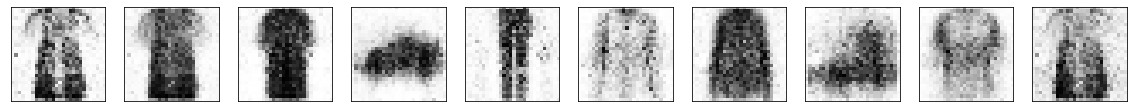

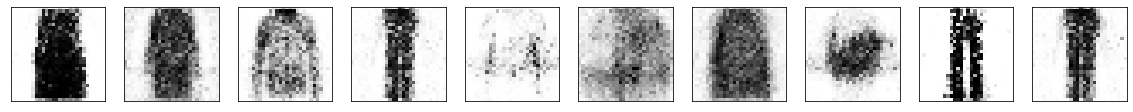

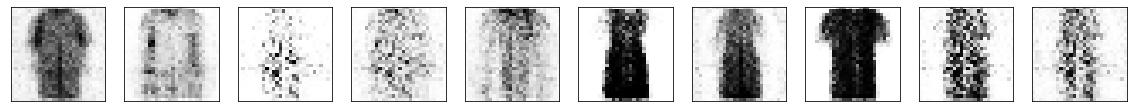

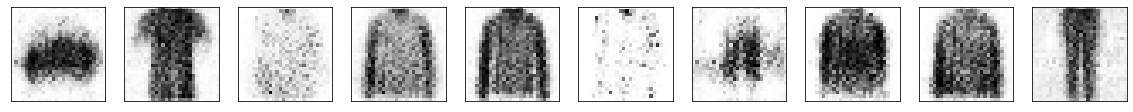

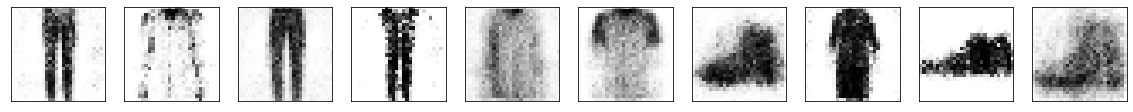

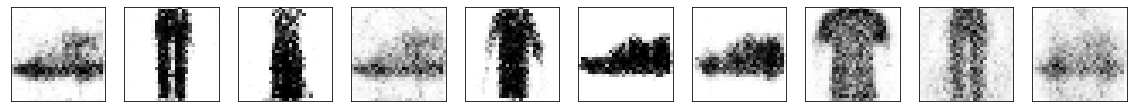

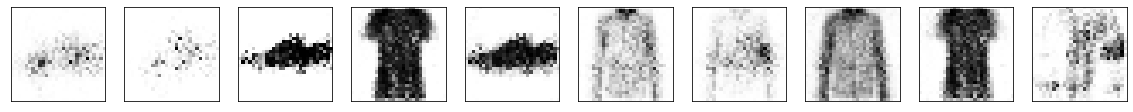

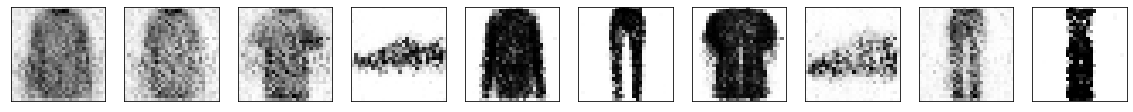

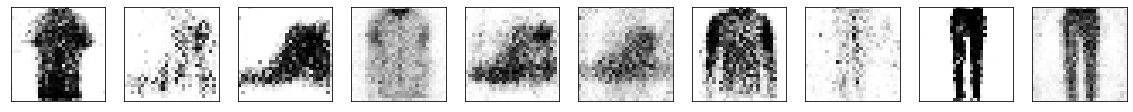

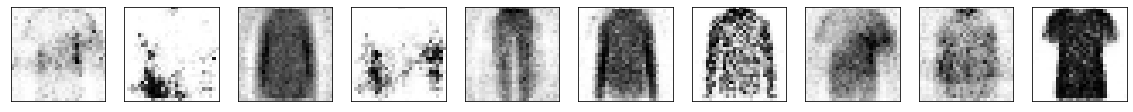

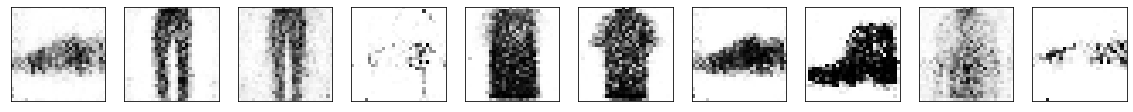

In [ ]:
epochs = 20 #반복 횟수를 정해줍니다.
batch_size = 128 #배치사이즈를 정해줍니다.
batch_count = x_train.shape[0] / batch_size  #데이터의 양을 배치사이즈 크기만큼 나눠서 학습시킵니다.

for epoch in range(1,epochs+1):
    for _ in tqdm(range(int(batch_count)), desc='epoch {}'.format(epoch)):
        #노이즈값 생성
        noise = np.random.normal(0,1, [batch_size, 100])

         #노이즈 값으로 이미지 생성 
        generated_images = generator.predict(noise)
        
        # 원본 데이터 batch_size만큼 추출 (랜덤으로)
        real_images =x_train[np.random.randint(0,x_train.shape[0],batch_size)]

        # 원본 데이터와 생성된 데이터 병합
        X= np.concatenate([real_images, generated_images])

        # D 라벨링 : 병합한 데이터의 라벨링
        y_dis = np.zeros(2*batch_size) 
        y_dis[:batch_size] = 0.9 #라벨 스무딩 : 라벨값을 0,1로 주는 것보다 0.1,0.9 식의 확률값으로 주는 것이 더 낫다.

        # D 학습 : fit 대신 train_on_batch 
        discriminator.train_on_batch(X, y_dis)

        # G 라벨링 : X'에 대한 라벨링 
        y_gen = np.ones(batch_size)
        
        # G 학습
        gan.train_on_batch(noise, y_gen) # input -> generator -> discriminator.trainable=F 


    # plot_generated_images(Epochs, generator)
    plt.figure(figsize=(20,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(generated_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.show()

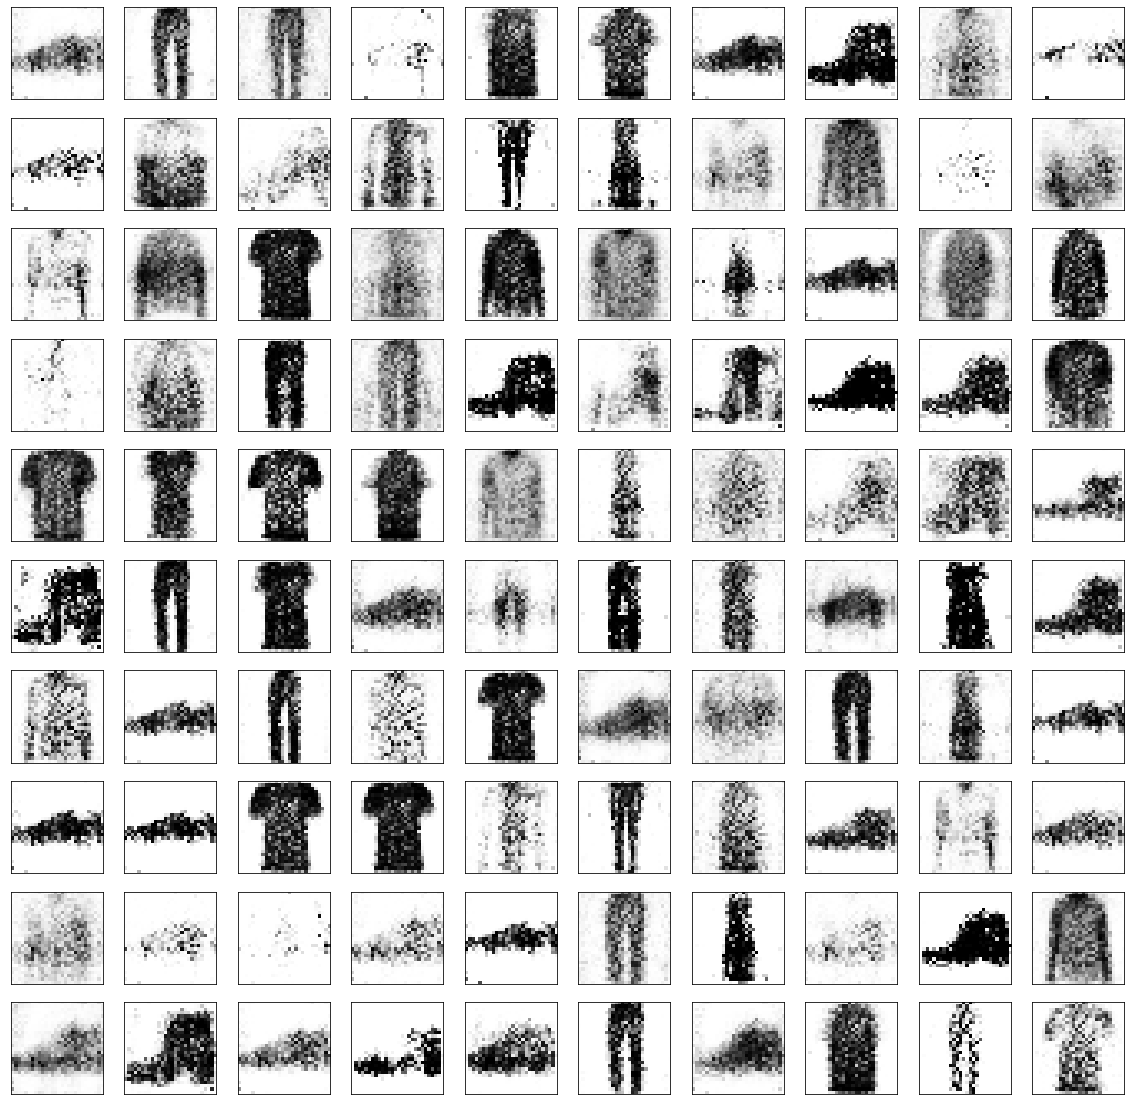

In [ ]:
# 최종 결과
plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(generated_images[i].reshape(28, 28), cmap=plt.cm.binary)
plt.show()